# Ideal observer for HMM beads

[1.   0.84 0.68 0.52 0.36 0.2 ]


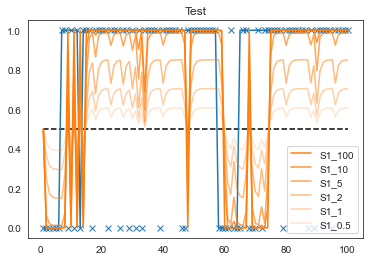

In [1]:
import numpy as np
import pandas as pd
from embo import EmpiricalBottleneck
import matplotlib.pyplot as plt
import seaborn as sns
import HMM_beads_utils as ut
import pickle as pkl
sns.set_style('white')
cmap = plt.get_cmap("tab10")

def gen_beads_trials(n,p,h):
    '''
    Function to generate stimuli
    INPUT:
        - n: number of trials
        - p: bernoulli probability
        - h: hazard rate
    OUTPUT:
        - pandas data frame with jar and bead for each trials 
    '''
    # Stimulus information beads and jars
    b_n_j = np.zeros((n,2))-1
    # Initialize current bead
    currBead = np.random.choice([0,1])
    # Iterate trhough trials to get jars
    for i in np.arange(n):
        # Apply hazard rate
        if np.random.uniform() < h:
            currBead = 1-currBead
        # Save jar
        b_n_j[i,1] = currBead
        
        # Generate bead
        b_n_j[i,0] = currBead
        if np.random.uniform()>p:
            b_n_j[i,0] = 1-currBead
    
    # Return data frame
    return(pd.DataFrame({
        'Trial':np.arange(1,n+1),
        'Jar':b_n_j[:,1],
        'Bead':b_n_j[:,0]
    }))
        

def add_noise(beta,prior,posterior):
    '''
    Helper function to add noise to simulated responses
    '''
    noisy_prior = 1/(1+np.exp(-beta*(prior-(1-prior))))
    noisy_posterior = 1/(1+np.exp(-beta*(posterior-(1-posterior))))
    return(noisy_prior,noisy_posterior,(np.random.uniform(size=len(prior))<noisy_prior).astype(int))

def gen_sim_pred(sname,beads,jars,p,h):
    '''
    Function to generate responses from the ideal observer with different internal estimates of p and h
    INPUT:
        - sname: subject identifier in data frame
        - beads: 1D array of observed bead sequence
        - jars: 1D array of jar sequence that generated beads
        - p: internal model estimate of the probability that the bead will match the generating jar
        - h: internal estimate of the hazard rate
    OUTPUT:
        -df: data frame with the following columns
            - Subject: subject ID + simulation type (from no noise to lots of noise)
            - Trial: trial number from start of experiment
            - Jar: jar generating the bead
            - Bead: bead observed on each trial
            - Prior: prior probability that the the jar generating the next bead = 1 (before observing the bead)
            - Posterior: posterior probability that the jar generating the last bead = 1 (after observing the bead)
            - Prediction: simulated prediction
    '''
    
    # Initialize
    p_jars = np.array([.5,.5])              # Initial prior
    likes = np.array([[p,(1-p)],[(1-p),p]]) # Likelihood
    prior = np.zeros(len(beads))            # Initialize trial-by-trial priors
    pred_hardmax = np.zeros(len(beads))     # Initialize hardmax predictions
    posterior = np.zeros(len(beads))        # Initialize trial-by-trial posteriors
    
    # Loop trhough all trials and get simulated responses
    for i in np.arange(len(beads)):
        # Apply hazard rate
        z1,z2 = tuple(p_jars.copy())
        p_jars = [(1-h)*z1 + h*z2, (1-h)*z2 + h*z1]

        #Save Prior
        prior[i] = p_jars[1]
        
        # Incorporate likelihood
        p_jars = p_jars*likes[int(beads[i])]
        p_jars = p_jars/sum(p_jars)
        
        # Save posterios
        posterior[i] = p_jars[1]
        
    # Get harmax predictions
    pred_hardmax[prior!=.5] = np.array(prior[prior!=.5] > .5).astype(int)
    pred_hardmax[prior==.5] = np.random.choice([0,1],size=len(prior[prior==.5]),replace=True)
    
    # Save data frame
    df = pd.DataFrame({
        'Subject':np.array([str(sname)+'_Hard']*len(beads)),
        'Trial':np.arange(1,len(beads)+1),
        'Jar':jars,
        'Bead':beads,
        'Prior':prior,
        'Posterior':posterior,
        'Prediction':pred_hardmax
    })
    
    # Add noisy responses - larger values == more deterministic (closer to hardmax)
    noises = [100,10,5,2,1,.5]  # Noise values from least to most noisy
    df_prime = df.copy()        # Initialize data frame
    for n in noises:
        noisy_prior,noisy_posterior,noisy_pred = add_noise(n,prior,posterior) # Add noise to ideal observer
        df2 = df_prime.copy()                                                 # Initialize second df (ugly)    
        df2['Prior'] = noisy_prior           # Save noisy prior                                       
        df2['Posterior'] = noisy_posterior   # Save noisy posterior
        df2['Prediction'] = noisy_pred       # Save noisy predictions based on above
        
        # Code to make up for my lack of generalizing skills
        if n >=1:
            df2['Subject'] = np.array([str(sname)+'_'+str(n)]*len(beads))
        else:
            df2['Subject'] = np.array([str(sname)+'_'+str(round(n,2))]*len(beads))
            
        # Append to data frame
        df = df.append(df2,ignore_index=True)
    return(df)
        


# Test bounds in each session
def get_windowed_mi(x,z,nw,base=2):
    '''
    Function that windows of observations from a sequence x offset from y and computes the MI
    Input:
        - x: sequence of "past" observations to be windowed
        - z: sequence that serves as the "future" events
        - nw: maximum window size
    Output:
        - mis: NSB estimated mutual informtion values for each window size
    '''
    mis = np.zeros(nw+1) #vector of mutual informations for different window sizes
    for w in np.arange(1,nw+1):
        xw,zw = ut.get_windowed_x(x,z,w=w,base=base)         # use convenience function from utilities to window x
        mis[w] = ut.mutual_inf_nsb(xw,zw,[base**w,2]) # use convenience function from utilities to compute NSB mutual info
    return(mis)

def get_windowed_mi_subs(sdat_all,nw):
    '''
    Function to compute windowed mutual information values for all subjects
    Input:
        - sdat_all: data frame with all of the subject tones, responses, and sources
        - nw: maximum window size to be considered
    Output:
        - Ipast for each window size and Ifuture
    '''
    # Create dictionaries to keep track of variables with subject IDs as the keys
    subs = pd.unique(sdat_all['Subject'])
    ip_sub = {}
    if_sub = {}
    # Loop through each subject and get their Ipast for windows up to nw and their ifuture
    for subi,sub in enumerate(subs):
        sdat = sdat_all[sdat_all['Subject'] == sub]                   # Get data from specific subject 
        ip_sub[sub] = get_windowed_mi(sdat['Bead'],sdat['Prediction'],nw)    # compute Ipast using function defined above 
        if_sub[sub] = ut.mutual_inf_nsb(sdat['Prediction'],sdat['Jar'],[2,2]) # compute Ifuture
    # Return dictionaries of ipast and ifuture values
    return(ip_sub,if_sub)

def get_windowed_bound(x,z,w,mb=50,nb=2000,p=8,base=2):
    '''
    Function that computes the information bottleneck bound between two discrete variables
    Input:
        - x: sequence of past events
        - z: sequence of future events
        - w: size of the window to be applied to x
        - mb: maximum value of the lagrange multiplier beta
        - nb: number of values of beta between 0 and mb to be run through the Blahaut-Arimoto algorithm
        - p: number of cores to use in the computation (to help with speed)
    Output:
        - 4 element tuple with a sequence of ipast and ifuture values corresponding to the information bottleneck for full and one back bounds
    '''
    # Get desired windowed x and corresponding z
    xw,zw = ut.get_windowed_x(x,z,w=w,base=base)
    
    # Compute the information bottleneck using EMBO for the window size w specified above
    ipw,ifw,betasw = EmpiricalBottleneck(xw,zw,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck() 
    
    # Compute the information bottleneck using EMBO for the window size w specified above
    x1b,z1b = ut.get_windowed_x(x,z,w=1,base=base)
    ip1b,if1b,betas1b = EmpiricalBottleneck(x1b,z1b,minsize=True,processes=p,maxbeta=mb,numbeta=nb).get_empirical_bottleneck() 
   
    # Return informtion bottleneck
    return((ipw,ifw,ip1b,if1b))

# Test
print(cmap)
n = 100
trials = gen_beads_trials(n,.8,.05)        
sim1 = gen_sim_pred('S1',trials['Bead'],trials['Jar'],.8,.05)

plt.plot(trials['Trial'],np.array([.5]*len(trials['Bead'])),'--k')
plt.plot(trials['Trial'],trials['Jar'],'-',color=cmap(0))
plt.plot(trials['Trial'],trials['Bead'],'x',color=cmap(0))
alphas=np.linspace(1,.2,num=6)
print(alphas)
for i,sub in enumerate(pd.unique(sim1['Subject'])[1:]):
    sim_dat = sim1.loc[sim1['Subject'] == sub].copy()
    plt.plot(trials['Trial'],sim_dat['Prior'],'-',color=cmap(1),alpha=alphas[i],label=sub)
plt.title('Test')
plt.legend()

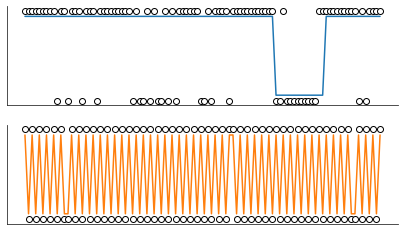

In [55]:
# Plot of example trials
np.random.seed(312315)
stimH1 = gen_beads_trials(100,.8,.02)
stimH1['Bead'].loc[stimH1['Bead']>0] = stimH1['Bead'].loc[stimH1['Bead']>0]+.07 
stimH1['Bead'].loc[stimH1['Bead']<1] = stimH1['Bead'].loc[stimH1['Bead']<1]-.07 
stimH9 = gen_beads_trials(100,1,.98)
stimH9['Bead'].loc[stimH9['Bead']>0] = stimH9['Bead'].loc[stimH9['Bead']>0]+.07 
stimH9['Bead'].loc[stimH9['Bead']<1] = stimH9['Bead'].loc[stimH9['Bead']<1]-.07 

plt.figure(1,(7,4))
plt.subplot(2,1,1)
plt.plot(stimH1['Jar'],color=cmap(0))
plt.plot(stimH1['Bead'],'o',mec='black',mfc='white')
plt.xticks([])
plt.yticks([])

plt.subplot(2,1,2)
plt.plot(stimH9['Jar'],color=cmap(1))
plt.plot(stimH9['Bead'],'o',mec='black',mfc='white',label='Bead Color')
plt.xticks([])
plt.yticks([])
sns.despine()

plt.savefig('./HMM_StimEx.eps')

In [4]:
%%time
# Generate large sequence of observations
n = 50000
h = .01
p = .8
stim_id = "H"+str(int(h*100))+"P"+(str(int(p*100)))+"50k"
try:
    stim = pkl.load(open("./HMM_sims/Stim_%s.p"%stim_id,"rb"))
    sim = pkl.load(open("./HMM_sims/SimIdeal_%s.p"%stim_id,"rb"))
    sim_H1 = pkl.load(open("./HMM_sims/SimH1_%s.p"%stim_id,"rb"))
    sim_H3 = pkl.load(open("./HMM_sims/SimH3_%s.p"%stim_id,"rb"))
    sim_H7 = pkl.load(open("./HMM_sims/SimH7_%s.p"%stim_id,"rb"))
    sim_H9 = pkl.load(open("./HMM_sims/SimH9_%s.p"%stim_id,"rb"))
    sim1b = pkl.load(open("./HMM_sims/Sim1b_%s.p"%stim_id,"rb"))
except:
    # Generate stimuli
    stim = gen_beads_trials(n,p,h)
    pkl.dump(stim,open("./HMM_sims/Stim_%s.p"%stim_id,"wb"))

    # Generate responses from ideal observer
    sim = gen_sim_pred('H.'+str(round(h,2)),stim['Bead'],stim['Jar'],p,h)
    pkl.dump(sim,open("./HMM_sims/SimIdeal_%s.p"%stim_id,"wb"))

    # Generate responses from model with incorrect hazard rates
    sim_H1 = gen_sim_pred('H.'+str(round(h,2)),stim['Bead'],stim['Jar'],p,.1)  #Subjective hazard rate = 0.1
    pkl.dump(sim_H1, open("./HMM_sims/SimH1_%s.p"%stim_id,"wb"))
    
    sim_H3 = gen_sim_pred('H.'+str(round(h,2)),stim['Bead'],stim['Jar'],p,.3)  #Subjective hazard rate = 0.3
    pkl.dump(sim_H3, open("./HMM_sims/SimH3_%s.p"%stim_id,"wb"))
    
    sim_H7 = gen_sim_pred('H.'+str(round(h,2)),stim['Bead'],stim['Jar'],p,.7)  #Subjective hazard rate = 0.7
    pkl.dump(sim_H7, open("./HMM_sims/SimH7_%s.p"%stim_id,"wb"))
    
    sim_H9 = gen_sim_pred('H.'+str(round(h,2)),stim['Bead'],stim['Jar'],p,.9)  #Subjective hazard rate = 0.9
    pkl.dump(sim_H9, open("./HMM_sims/SimH9_%s.p"%stim_id,"wb"))

    # Generate responses from model only looking one back
    sim1b = gen_sim_pred('H.'+str(round(h,2))+'1b',stim['Bead'],stim['Jar'],1,h)
    pkl.dump(sim1b, open("./HMM_sims/Sim1b_%s.p"%stim_id,"wb"))

CPU times: user 279 ms, sys: 131 ms, total: 410 ms
Wall time: 423 ms


CPU times: user 23.1 ms, sys: 2.43 ms, total: 25.6 ms
Wall time: 24.5 ms


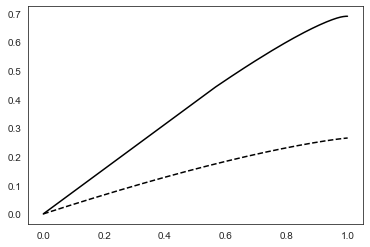

In [5]:
%%time
# Get optimal bound (full and 1back)
nw = 10
try:
    ipw,ifw,ip1b,if1b = pkl.load(open('./HMM_bounds/IB_H'+str(int(h*100))+'P'+str(int(p*100))+'NW'+str(nw)+'.p','rb'))
except:
    ipw,ifw,ip1b,if1b = get_windowed_bound(stim['Bead'],stim['Jar'],10)
    pkl.dump((ipw,ifw,ip1b,if1b),open('./HMM_bounds/IB_H'+str(int(h*100))+'P'+str(int(p*100))+'NW'+str(nw)+'.p','wb'))
plt.plot(ipw,ifw,'-k')
plt.plot(ip1b,if1b,'--k')

In [27]:
%%time
nw = 10
try:
    ip_subs,if_subs = pkl.load(open("./HMM_sims_ipred/sim_ip_if_H"+str(h*100)+"P"+str(p*100)+"NW"+str(nw)+".p","rb"))
except:
    sims = [sim,sim1b,sim_H1,sim_H3,sim_H7,sim_H9]
    sim_names = ['Ideal','1back','H1','H3','H7','H9']
    ip_subs = {}
    if_subs = {}
    for i,sn in enumerate(sim_names):
        print(sn)
        ip_subs[sn],if_subs[sn] = get_windowed_mi_subs(sims[i],nw)
    pkl.dump((ip_subs,if_subs),open("./HMM_sims_ipred/sim_ip_if_H"+str(h*100)+"P"+str(p*100)+"NW"+str(nw)+".p","wb"))

CPU times: user 754 µs, sys: 1.01 ms, total: 1.76 ms
Wall time: 5.71 ms


(0.0, 1.0)

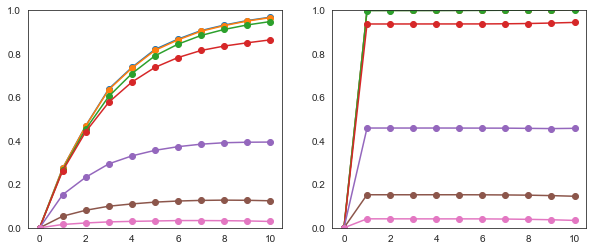

In [55]:
plt.figure(1,(10,4))
plt.subplot(1,2,1)
ip_sub = ip_subs['Ideal']
for sub in pd.unique([key for key in ip_sub.keys()]):
    plt.plot(ip_sub[sub],'-o',label=sub)
plt.ylim([0,1])

plt.subplot(1,2,2)
ip_sub_1b = ip_subs['1back']
for sub in pd.unique([key for key in ip_sub_1b.keys()]):
    plt.plot(ip_sub_1b[sub],'-o',label=sub)
plt.ylim([0,1])

In [28]:
# Markov environment
mmn = 50000
mmh = .1
mmp = 1
mmstim = gen_beads_trials(mmn,mmp,mmh)

# Get markov simulations
mmsim = gen_sim_pred('H.'+str(round(mmh,2)),mmstim['Bead'],mmstim['Jar'],mmp,mmh)

# Get non-markov simulation
def non_markov(beads,jars):
    predictions = np.zeros(len(beads))
    for i in np.arange(len(beads)):
        if i <2:
            predictions[i] = np.random.choice([0,1])
        else:
            predictions[i] = int(beads[i-2]==beads[i-1])
    return(pd.DataFrame({
        'Subject':['NonMM']*len(beads),
        'Bead':beads,
        'Jar':jars,
        'Prediction':predictions
    }))

nmmsim = non_markov(mmstim['Bead'],mmstim['Jar'])

# Compute bound (2 back should be fine)
mmnw = 6
mmipw,mmifw,mmip1b,mmif1b = get_windowed_bound(mmstim['Bead'],mmstim['Jar'],mmnw)

# Get complexity for simulations
mmsims = [mmsim,nmmsim]
mmsim_names = ['Ideal','NonMM']
mmip_subs = {}
mmif_subs = {}
for i,sn in enumerate(mmsim_names):
    print(sn)
    mmip_subs[sn],mmif_subs[sn] = get_windowed_mi_subs(mmsims[i],mmnw)

Ideal
NonMM


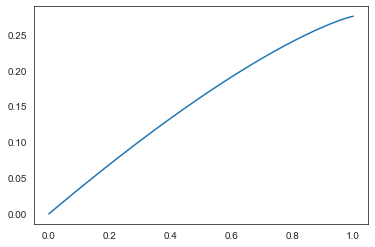

In [15]:
plt.plot(mmipw,mmifw)

In [32]:
mmif_subs

{'Ideal': {'H.0.1_Hard': 0.5272798666883575,
  'H.0.1_100': 0.5272170766023184,
  'H.0.1_10': 0.5263353512632432,
  'H.0.1_5': 0.48055042277446175,
  'H.0.1_2': 0.21512426956019579,
  'H.0.1_1': 0.06805405272629891,
  'H.0.1_0.5': 0.018125196941542198},
 'NonMM': {'NonMM': -3.0978305609414925e-05}}

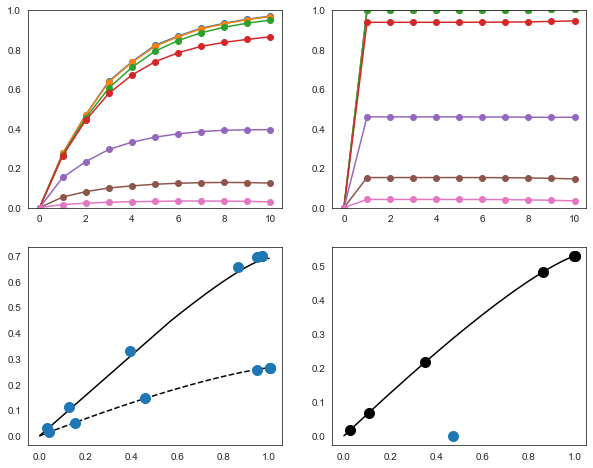

In [57]:
ideal_ips = np.zeros(7)
ideal_ifs = np.zeros(7)
for i,model in enumerate(ip_subs['Ideal'].keys()):
    ideal_ips[i] = ip_subs['Ideal'][model].max()
    ideal_ifs[i] = if_subs['Ideal'][model].max()
    
oneb_ips = np.zeros(7)
oneb_ifs = np.zeros(7)
for i,model in enumerate(ip_subs['1back'].keys()):
    oneb_ips[i] = ip_subs['1back'][model].max()
    oneb_ifs[i] = if_subs['1back'][model].max()

plt.figure(1,(10,8))
plt.subplot(2,2,1)
ip_sub = ip_subs['Ideal']
for sub in pd.unique([key for key in ip_sub.keys()]):
    plt.plot(ip_sub[sub],'-o',label=sub)
plt.ylim([0,1])

plt.subplot(2,2,2)
ip_sub_1b = ip_subs['1back']
for sub in pd.unique([key for key in ip_sub_1b.keys()]):
    plt.plot(ip_sub_1b[sub],'-o',label=sub)
plt.ylim([0,1])

plt.subplot(2,2,3)
plt.plot(ipw,ifw,'-k')
plt.plot(ip1b,if1b,'--k')
plt.plot(ideal_ips,ideal_ifs,'o',color=cmap(0),markersize=10)
plt.plot(oneb_ips,oneb_ifs,'o',color=cmap(0),markersize=10)


mm_ips = np.zeros(7)
mm_ifs = np.zeros(7)
for i,model in enumerate(mmip_subs['Ideal'].keys()):
    mm_ips[i] = mmip_subs['Ideal'][model].max()
    mm_ifs[i] = mmif_subs['Ideal'][model].max()
    
plt.subplot(2,2,4)
plt.plot(mmipw,mmifw,'-k')
plt.plot(mm_ips,mm_ifs,'ok',markersize=10)
plt.plot(mmip_subs['NonMM']['NonMM'].max(),mmif_subs['NonMM']['NonMM'].max(),'o',markersize=10)
plt.savefig('./HMM_sims/HMM_bounds_ipred_sims.eps')